In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import linalg
import os
from math import *
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

## Find parameters H and Nu of IV_ATM Rough model for different expiries using the Scaling of $m(q,\Delta)$ with lag $\Delta$

In [3]:
spy = pd.read_csv("SPY__constantMaturityImpliedVStatistics.csv")

In [4]:
spy.head()

,date,spot,fwd_W2,fwd_M1,fwd_W6,fwd_M2,fwd_M3,fwd_M4,fwd_M5,fwd_M6,...,skew_M5,skew_M6,conv_W2,conv_M1,conv_W6,conv_M2,conv_M3,conv_M4,conv_M5,conv_M6
0,20080102,145.132007,145.132007,145.370294,145.566433,145.549364,145.593860,145.837113,146.080365,146.304170,...,-0.057589,-0.056787,0.001107,-0.000293,-0.003108,-0.003999,-0.003841,-0.004252,-0.004230,-0.004136
1,20080103,145.119163,145.119163,145.366847,145.556487,145.546948,145.633973,145.883753,146.133533,146.334559,...,-0.055792,-0.055157,-0.001061,-0.003243,-0.005667,-0.005967,-0.005085,-0.005292,-0.004754,-0.004224
2,20080104,141.468056,141.468056,141.710360,141.886066,141.854393,141.929284,142.148660,142.368037,142.555189,...,-0.054916,-0.053932,0.000564,-0.000721,-0.002928,-0.004448,-0.006070,-0.005698,-0.004129,-0.003016
3,20080107,141.801433,141.843656,142.095885,142.228671,142.207812,142.302168,142.492872,142.683576,142.871456,...,-0.054546,-0.054142,-0.001156,-0.002234,-0.002858,-0.003821,-0.004740,-0.004752,-0.003980,-0.003576
4,20080108,138.987895,139.044448,139.287657,139.394845,139.356368,139.443529,139.627972,139.812415,139.979711,...,-0.056366,-0.056321,0.002408,-0.000564,-0.004317,-0.004453,-0.004463,-0.004837,-0.004655,-0.004566


<h3 id="The-smoothness-of-the-volatility-process">The smoothness of the volatility process<a class="anchor-link" href="#The-smoothness-of-the-volatility-process">¶</a></h3><p>For $q\geq 0$, we define the $q$th sample moment of differences of log-volatility at a given lag $\Delta$ denotes the sample average):</p>
$$
m(q,\Delta)=<\left|\log \sigma_{t+\Delta} -\log \sigma_{t} \right|^q>
$$<p>For example</p>
$$
m(2,\Delta)=<\left(\log \sigma_{t+\Delta} -\log \sigma_{t} \right)^2>
$$<p>is just the sample variance of differences in log-volatility at the lag $\Delta$.</p>

In [18]:
maturity = "M1"
moneyness = -3

In [19]:
spy["iv_"+maturity+"_"+str(moneyness)] = spy["level_"+maturity]+spy["skew_"+maturity]*moneyness \
    +spy["conv_"+maturity]*(moneyness**2)

In [20]:
spy.head()

,date,spot,fwd_W2,fwd_M1,fwd_W6,fwd_M2,fwd_M3,fwd_M4,fwd_M5,fwd_M6,...,conv_M3,conv_M4,conv_M5,conv_M6,iv_M1_-3,iv_M1_-3_sqrt,iv_M1_-3_log_sqrt,iv_M1_0,iv_M1_0_sqrt,iv_M1_0_log_sqrt
0,20080102,145.132007,145.132007,145.370294,145.566433,145.549364,145.593860,145.837113,146.080365,146.304170,...,-0.003841,-0.004252,-0.004230,-0.004136,0.342767,0.585463,-0.535353,0.221747,0.470900,-0.753109
1,20080103,145.119163,145.119163,145.366847,145.556487,145.546948,145.633973,145.883753,146.133533,146.334559,...,-0.005085,-0.005292,-0.004754,-0.004224,0.309103,0.555970,-0.587041,0.217869,0.466765,-0.761930
2,20080104,141.468056,141.468056,141.710360,141.886066,141.854393,141.929284,142.148660,142.368037,142.555189,...,-0.006070,-0.005698,-0.004129,-0.003016,0.332794,0.576883,-0.550116,0.234117,0.483857,-0.725967
3,20080107,141.801433,141.843656,142.095885,142.228671,142.207812,142.302168,142.492872,142.683576,142.871456,...,-0.004740,-0.004752,-0.003980,-0.003576,0.319153,0.564936,-0.571043,0.227176,0.476630,-0.741015
4,20080108,138.987895,139.044448,139.287657,139.394845,139.356368,139.443529,139.627972,139.812415,139.979711,...,-0.004463,-0.004837,-0.004655,-0.004566,0.355819,0.596506,-0.516666,0.248354,0.498351,-0.696451


In [21]:
#col = 'level_M1'
col = "iv_"+maturity+"_"+str(moneyness)
spy[col+'_sqrt']= np.sqrt(spy[col])
spy[col+'_log_sqrt'] = np.log(spy[col+'_sqrt'])

def del_Raw(q, x): 
    return [np.mean(np.abs(spy[col+'_log_sqrt'] - spy[col+'_log_sqrt'].shift(lag)) ** q)
            for lag in x]


[0.13727780183443541, 0.2652832520868928, 0.375887694269328, 0.46370798805640717, 0.5768132598995384]


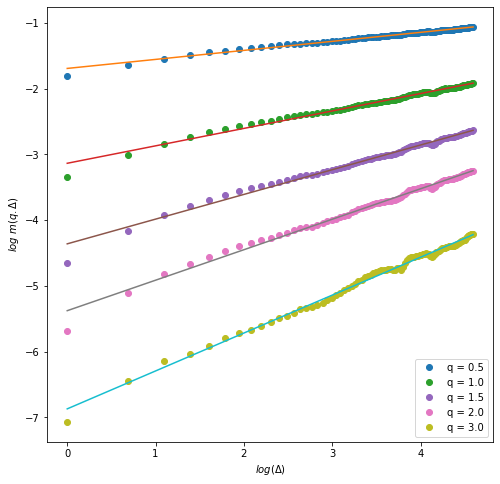

In [22]:

plt.figure(figsize=(8, 8))
plt.xlabel('$log(\Delta)$')
plt.ylabel('$log\  m(q.\Delta)$')
plt.ylim=(-3, -.5)

zeta_q = list()
qVec = np.array([.5, 1, 1.5, 2, 3])
x = np.arange(1, 100)
for q in qVec:
    plt.plot(np.log(x), np.log(del_Raw(q, x)), 'o', label="q = "+str(q)) 
    model = np.polyfit(np.log(x), np.log(del_Raw(q, x)), 1)
    plt.plot(np.log(x), np.log(x) * model[0] + model[1])
    zeta_q.append(model[0])
plt.legend()
print(zeta_q)




<h3 id="Monofractal-scaling-result">Monofractal scaling result<a class="anchor-link" href="#Monofractal-scaling-result">¶</a></h3><ul>
<li>From the above log-log plot, we see that for each $q$, $m(q,\Delta) \propto \Delta ^{\zeta_q}$.</li>
</ul>
<ul>
<li>How does $\zeta_q$ scale with $q$?</li>
</ul>



<h3 id="Scaling-of-$\zeta_q$-with-$q$">Scaling of $\zeta_q$ with $q$<a class="anchor-link" href="#Scaling-of-$\zeta_q$-with-$q$">¶</a></h3>


0.21797900016967015


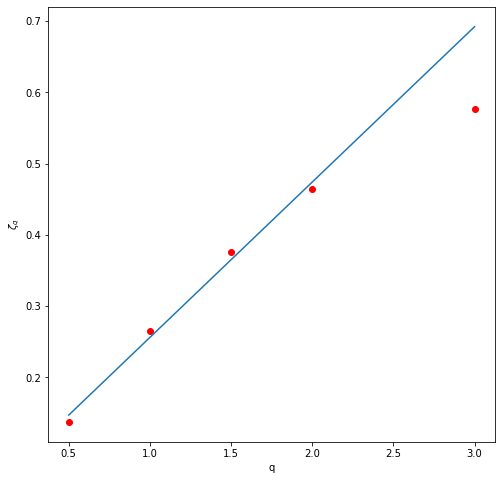

In [23]:

plt.figure(figsize=(8,8))
plt.xlabel('q')
plt.ylabel('$\zeta_{q}$')
plt.plot(qVec, zeta_q, 'or')

line = np.polyfit(qVec[:4], zeta_q[:4],1)
plt.plot(qVec, line[0] * qVec + line[1])
h_est= line[0]
print(h_est)




<p>We find the monofractal scaling relationship</p>
$$
\zeta_q = q\,H
$$<p>with $H \approx 0.13$.</p>
<ul>
<li>Note however that $H$ does vary over time, in a narrow range.</li>
</ul>
<ul>
<li>Note also that our estimate of $H$ is biased high because we proxied instantaneous variance $v_t$ with its average over each day $\frac 1T\,\int_0^T\,v_t\,dt$, where $T$ is one trading day.</li>
</ul>


In [469]:

def dlsig2(sic, x, pr=False):
    if pr:
        a= np.array([(sig-sig.shift(lag)).dropna() for lag in x])
        a=a ** 2
        print(a.info())
    return [np.mean((sig-sig.shift(lag)).dropna() ** 2) for lag in x]



In [556]:

h = list()
nu = list()
maturity_list = ["W2","M1","W6","M2","M3","M4","M5","M6"]
moneyness = -1
cols = []

for maturity in maturity_list:
    cols.append("iv_"+maturity+"_"+str(moneyness))
    sig = spy["level_"+maturity]+spy["skew_"+maturity]*moneyness+spy["conv_"+maturity]*(moneyness**2)
    sig = np.log(np.sqrt(sig))
    sig = sig.dropna()
    model = np.polyfit(np.log(x), np.log(dlsig2(sig, x)), 1)
    nu.append(np.sqrt(np.exp(model[1])))
    h.append(model[0]/2.)
    
stats = pd.DataFrame({'names':cols, 'h_est': h, 'nu_est': nu})

In [555]:
stats

,names,h_est,nu_est
0,iv_W2_0,0.291220,0.060695
1,iv_M1_0,0.333519,0.043747
2,iv_W6_0,0.352674,0.037214
3,iv_M2_0,0.368979,0.031544
4,iv_M3_0,0.384708,0.025979
5,iv_M4_0,0.394686,0.022543
6,iv_M5_0,0.402445,0.020197
7,iv_M6_0,0.411409,0.018302


In [557]:
stats

,names,h_est,nu_est
0,iv_W2_-1,0.254637,0.072806
1,iv_M1_-1,0.311604,0.048919
2,iv_W6_-1,0.340665,0.039832
3,iv_M2_-1,0.360692,0.033252
4,iv_M3_-1,0.380001,0.027012
5,iv_M4_-1,0.391799,0.023268
6,iv_M5_-1,0.401515,0.020722
7,iv_M6_-1,0.412223,0.018653


In [553]:
stats

,names,h_est,nu_est
0,iv_W2_-3,0.145410,0.124983
1,iv_M1_-3,0.231854,0.067964
2,iv_W6_-3,0.326783,0.038993
3,iv_M2_-3,0.355212,0.031273
4,iv_M3_-3,0.377786,0.025387
5,iv_M4_-3,0.390839,0.021940
6,iv_M5_-3,0.407065,0.019106
7,iv_M6_-3,0.421488,0.017104


In [488]:
def compute_year_frac(s):
    a=s.split("_")[1]
    if a[0] == "W":
        res = (int(a[1])*7)/365
    elif a[0] == "M":
        res = (int(a[1])*30)/365
    return res

stats["year_frac"] = stats["names"].apply(lambda s: compute_year_frac(s))

In [489]:
stats

,names,h_est,nu_est,year_frac
0,level_W2,0.291220,0.060695,0.038356
1,level_M1,0.333519,0.043747,0.082192
2,level_W6,0.352674,0.037214,0.115068
3,level_M2,0.368979,0.031544,0.164384
4,level_M3,0.384708,0.025979,0.246575
5,level_M4,0.394686,0.022543,0.328767
6,level_M5,0.402445,0.020197,0.410959
7,level_M6,0.411409,0.018302,0.493151


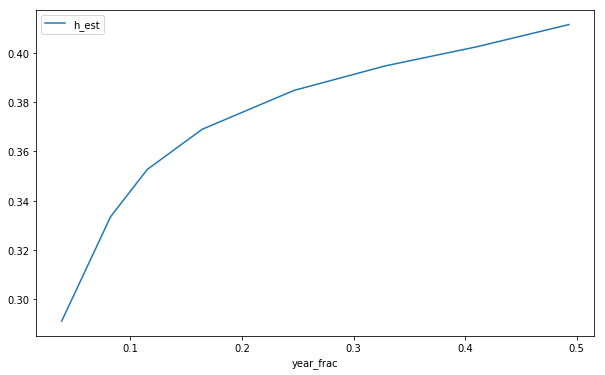

In [491]:
stats.plot(x="year_frac",y="h_est",figsize=(10,6))

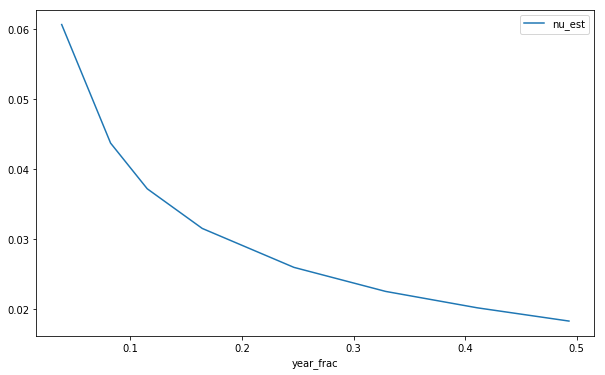

In [500]:
stats.plot(x="year_frac",y="nu_est",figsize=(10,6))